In [83]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

path = "C:\\Users\\Abhud\\Documents\\projects\\Data\\Tableau\\Inflation\\Inflation.csv"

df = pd.read_csv(path)

In [84]:
df.columns=["Date","CPI"]

In [85]:
df.tail()


,Date,CPI
119,12/1/2022,296.797
120,1/1/2023,299.170
121,2/1/2023,300.840
122,3/1/2023,301.836
123,4/1/2023,303.363


In [86]:
df['Date']=pd.to_datetime(df['Date'], format="%m/%d/%Y")


In [87]:
df['Date']

0     2013-01-01
1     2013-02-01
2     2013-03-01
3     2013-04-01
4     2013-05-01
         ...    
119   2022-12-01
120   2023-01-01
121   2023-02-01
122   2023-03-01
123   2023-04-01
Name: Date, Length: 124, dtype: datetime64[ns]

In [88]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [89]:
y = df['CPI'].fillna(method='ffill')


In [90]:
# reshaping close column or variable y from main data set 
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)


In [96]:
# generate the input and output sequences
n_lookback = 12  # length of input sequences (lookback period)
n_forecast = 8  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [97]:
# fit the model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=100))
model.add(Dense(n_forecast))



In [98]:
# declare epoch and batch size to train 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=8, verbose=0)


In [99]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)


1/1 [==============================] - 1s 912ms/step


C:\Users\Abhud\AppData\Local\Temp\ipykernel_19844\2692913228.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


<AxesSubplot:title={'center':'CPI'}, xlabel='Date'>

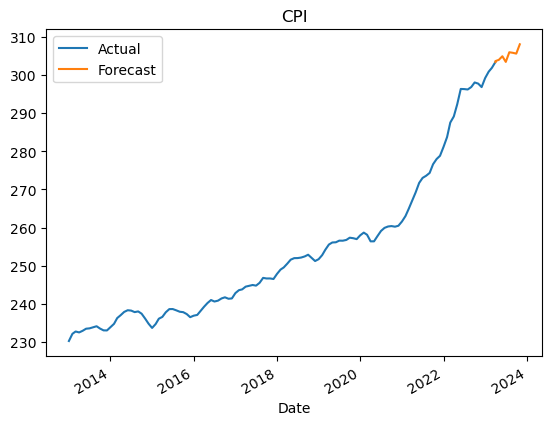

In [100]:
# organize the results in a data frame
df_past = df[['Date','CPI']]
df_past.rename(columns={'index': 'Date', 'CPI': 'Actual'}, inplace=True)
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] ,freq='MS', periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='CPI')

In [101]:
df_future


,Date,Actual,Forecast
0,2023-04-01,NaN,303.605652
1,2023-05-01,NaN,303.933990
2,2023-06-01,NaN,304.878601
3,2023-07-01,NaN,303.395630
4,2023-08-01,NaN,305.924103
5,2023-09-01,NaN,305.779022
6,2023-10-01,NaN,305.571716
7,2023-11-01,NaN,308.012512


In [102]:
df_future = df_future.drop(columns=['Actual'])

In [103]:
df_past = df_past.drop(columns=['Forecast'])

In [104]:
df_future.to_csv('ForecastCPI.csv')


In [105]:
df_past.to_csv('PastCPI.csv')